## Import Libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from ipywidgets import interactive
from matplotlib_venn import venn3

## Import Database:

In [2]:
dataset = pd.read_csv('C:\\Users\Ania\\Desktop\\ESG\\SP 500 ESG Risk Ratings.csv', sep=',')
print(f'Shape of dataset: {dataset.shape}')

## Capitalize every word in column name as they were mixed
dataset.columns = [' '.join(word[0].upper() + word[1:] for word in col.split()) for col in dataset.columns]

## Dispay data with with complete scores:
scores_complete = dataset.loc[~(dataset[['Environment Risk Score', 'Governance Risk Score', 'ESG Risk Percentile', 'ESG Risk Level']].isnull().any(axis=1))]
print(f'Shape of dataset with all scores complete: {scores_complete.shape}')
scores_complete.head(3)

Shape of dataset: (503, 15)
Shape of dataset with all scores complete: (430, 15)


,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk Score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Level,Controversy Score,ESG Risk Percentile,ESG Risk Level
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,"14,000",Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,Moderate Controversy Level,2.0,50th percentile,Medium
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,"6,500","Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,Moderate Controversy Level,2.0,66th percentile,Medium
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,"70,000",DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,Moderate Controversy Level,2.0,38th percentile,Medium


## First Glance Summary

In [3]:
describe_dataset = (
    dataset.describe()
    .drop('count', axis=0)
    .style
    .background_gradient(axis=0, cmap='viridis')
    .set_properties(**{'text-align': 'center'}) 
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('font-family', 'Arial'),  
            ('font-weight', 'normal'),  
            ('font-size', '14px'),  
        ]},
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-family', 'Arial'), 
            ('font-weight', 'bold'),  
            ('font-size', '14px'),  
        ]}
    ])
    .set_caption('First Glance Statistics')  
)

describe_dataset

,Total ESG Risk Score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Score
mean,21.533721,5.739767,6.725116,9.070465,2.007444
std,6.889176,5.092421,2.208085,3.657924,0.793283
min,7.100000,0.000000,3.000000,0.800000,1.000000
25%,16.400000,1.800000,5.300000,6.700000,1.000000
50%,21.050000,4.050000,6.100000,8.900000,2.000000
75%,26.000000,8.950000,7.675000,11.200000,2.000000
max,41.700000,25.000000,19.400000,22.500000,5.000000


In [4]:

def check_data(dataset):
    check = []
    columns = dataset.columns
    for column in columns:
        instances = dataset[column].count()
        dtypes = dataset[column].dtype
        unique = dataset[column].nunique()
        sum_null = dataset[column].isnull().sum()
        duplicates = dataset.duplicated().sum()
        check.append([column, dtypes, instances, unique, sum_null, duplicates])
    data_check = pd.DataFrame(check, columns=['column', 'dtype', 'instances', 'unique', 'sum_null', 'duplicates'])
    return data_check

## Incoke function:
data_check = check_data(dataset)


data_check = (
    check_data(dataset)
    .style
    .background_gradient(axis=0, cmap='viridis')
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('font-family', 'Arial'),  
            ('font-weight', 'normal'),  
            ('font-size', '14px'),  
        ]},
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-family', 'Arial'), 
            ('font-weight', 'bold'),  
            ('font-size', '14px'),  
        ]}
    ])
    .set_caption('Dataset Prelimiary Analysis')
)

data_check

,column,dtype,instances,unique,sum_null,duplicates
0,Symbol,object,503,503,0,0
1,Name,object,503,503,0,0
2,Address,object,502,498,1,0
3,Sector,object,502,11,1,0
4,Industry,object,502,116,1,0
5,Full Time Employees,object,498,394,5,0
6,Description,object,502,499,1,0
7,Total ESG Risk Score,float64,430,213,73,0
8,Environment Risk Score,float64,430,146,73,0
9,Governance Risk Score,float64,430,91,73,0


## Remove nulls from selected columns:

In [5]:
dataset.dropna(subset=['Sector', 'Industry', 'Total ESG Risk Score'])
print(f'Dataset shape after dropping NaN values from selected columns: {dataset.shape}') 

Dataset shape after dropping NaN values from selected columns: (503, 15)


## Average Total ESG Risk Analysis by Sector:

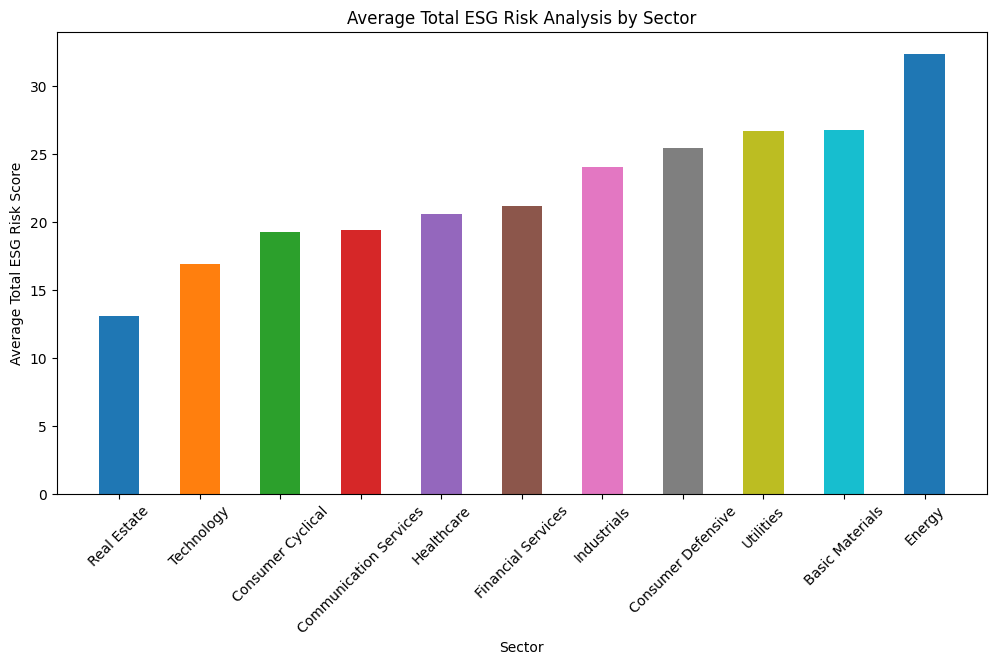

In [6]:
average_total_esg_score =  dataset.groupby('Sector')['Total ESG Risk Score'].mean().reset_index().sort_values(by='Total ESG Risk Score')

fig = plt.figure(figsize= (12, 6))
colors = plt.get_cmap('tab10').colors
plt.bar(average_total_esg_score['Sector'], average_total_esg_score['Total ESG Risk Score'], color=colors[:len(average_total_esg_score)], width=0.5)
plt.xticks(rotation=45)
plt.xlabel('Sector')
plt.ylabel('Average Total ESG Risk Score')
plt.title('Average Total ESG Risk Analysis by Sector')
plt.show()


## Total ESG Risk Top 10 Performers By Sector:

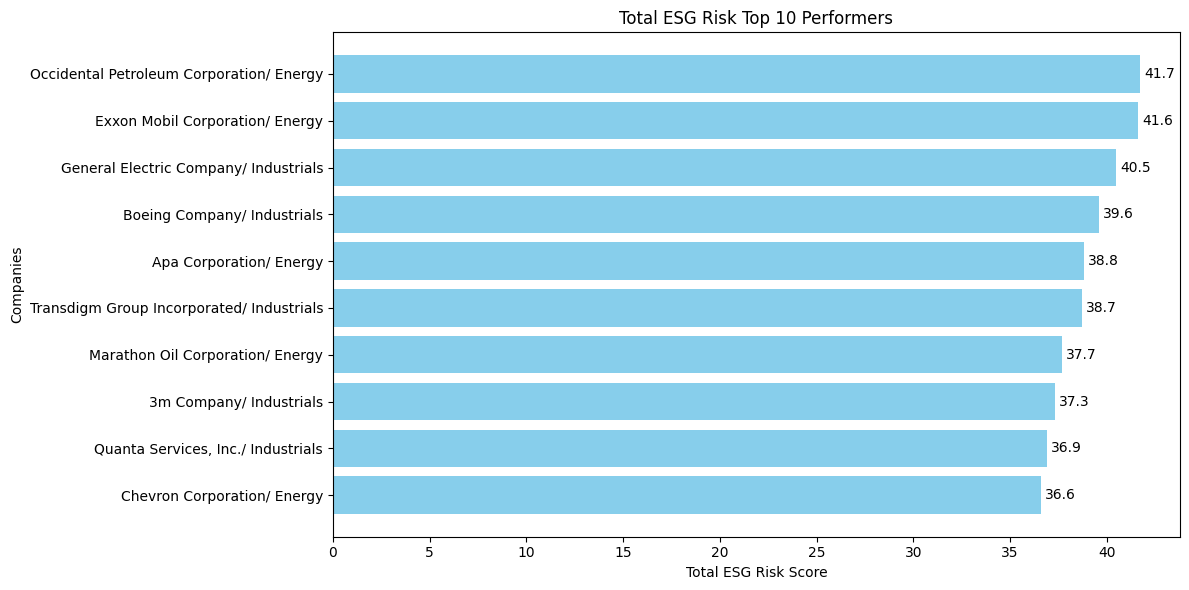

In [7]:
# sort data
top_10_performers = dataset.sort_values(by=['Total ESG Risk Score'], ascending=False).head(10).reset_index()

# add sector to company name
top_10_performers['Company_Sector'] = top_10_performers['Name'] + '/ ' + top_10_performers['Sector']

fig, ax = plt.subplots(figsize=(12,6))
bars = ax.barh(top_10_performers['Company_Sector'][::-1], top_10_performers['Total ESG Risk Score'][::-1], color='skyblue')
ax.bar_label(bars, fmt='%.1f', padding=3)
plt.xlabel('Total ESG Risk Score')
plt.ylabel('Companies')
plt.title('Total ESG Risk Top 10 Performers')
plt.tight_layout()
plt.show()

## Standard Normal Distribution:

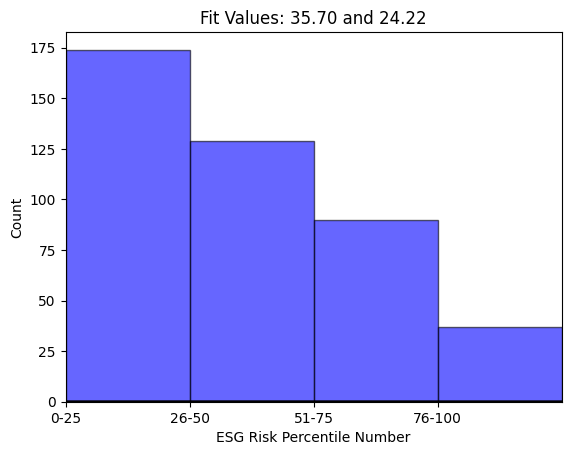

In [8]:
dataset = dataset.copy()
dataset['ESG Risk Percentile Number'] = dataset['ESG Risk Percentile'].str.extract('(\d+)').astype(float)
dataset = dataset.dropna(subset=['ESG Risk Percentile Number'])

mu, std = norm.fit(dataset['ESG Risk Percentile Number'])
bins = [0, 25, 50, 75, 100]
bin_labels = ['0-25', '26-50', '51-75', '76-100']

# Plot the histogram
plt.hist(dataset['ESG Risk Percentile Number'], bins=bins, density=False, alpha=0.6, color='b', edgecolor='black')

xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100)

# Plot the PDF
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Adjust x-axis limits to fit the bins
plt.xlim(min(bins), max(bins))

# Add labels for bins on x-axis
plt.xticks(ticks=bins[:-1], labels=bin_labels)

title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.xlabel('ESG Risk Percentile Number')
plt.ylabel('Count')

plt.show()

## Bar Charts and Histograms of ESG scores:

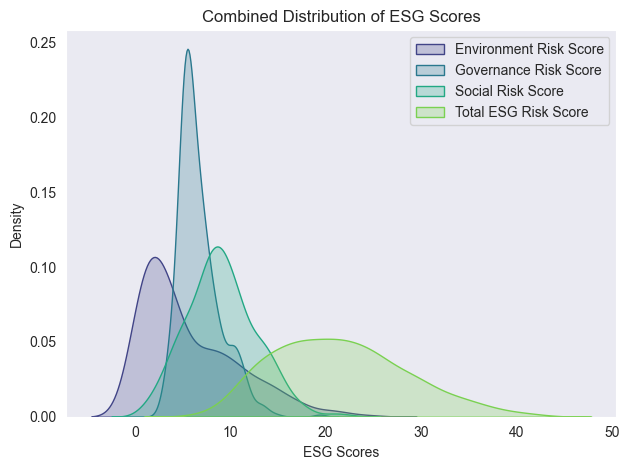

In [9]:
esg_scores = dataset[['Environment Risk Score', 'Governance Risk Score', 'Social Risk Score', 'Total ESG Risk Score']]
esg_scores

sns.set_style(style="dark")
colors = colors = sns.color_palette("viridis", len(esg_scores.columns))

for col, color in zip(esg_scores.columns, colors):
    sns.kdeplot(
        data=esg_scores[col],
        label=col,
        color=color,
        fill=True
    )

plt.xlabel('ESG Scores')
plt.ylabel('Density')
plt.title('Combined Distribution of ESG Scores')

plt.legend()

plt.tight_layout()
plt.show()

In [10]:
#Venn diagrams: 1) biorę score social, daję kwadryl 1-25 % i patrzę, ile razy ten sam sektor tam jest, np czy jest taki sektor dołuje z tych danych, i tak zrobić dla każdego score'a

## Corelation between scores:

##### usegul links: https://www.geeksforgeeks.org/grid-plot-in-python-using-seaborn/

In [11]:
scores = dataset[['Environment Risk Score', 'Governance Risk Score', 'Social Risk Score']]

def size_widget(height, aspect):
    g = sns.pairplot(scores, 
                 kind='reg', 
                 diag_kind='kde',
                 plot_kws={'ci': None, 'color': 'red',
                           'scatter_kws': {'color': 'grey', 's': 4}
                          }
                )

interactive(size_widget, height=(1, 3.5, 0.5), aspect=(0.5, 2, 0.25))

interactive(children=(FloatSlider(value=2.0, description='height', max=3.5, min=1.0, step=0.5), FloatSlider(va…

## Venn diagram to check which sectors appear in the lowest quadrile 0 - 25:

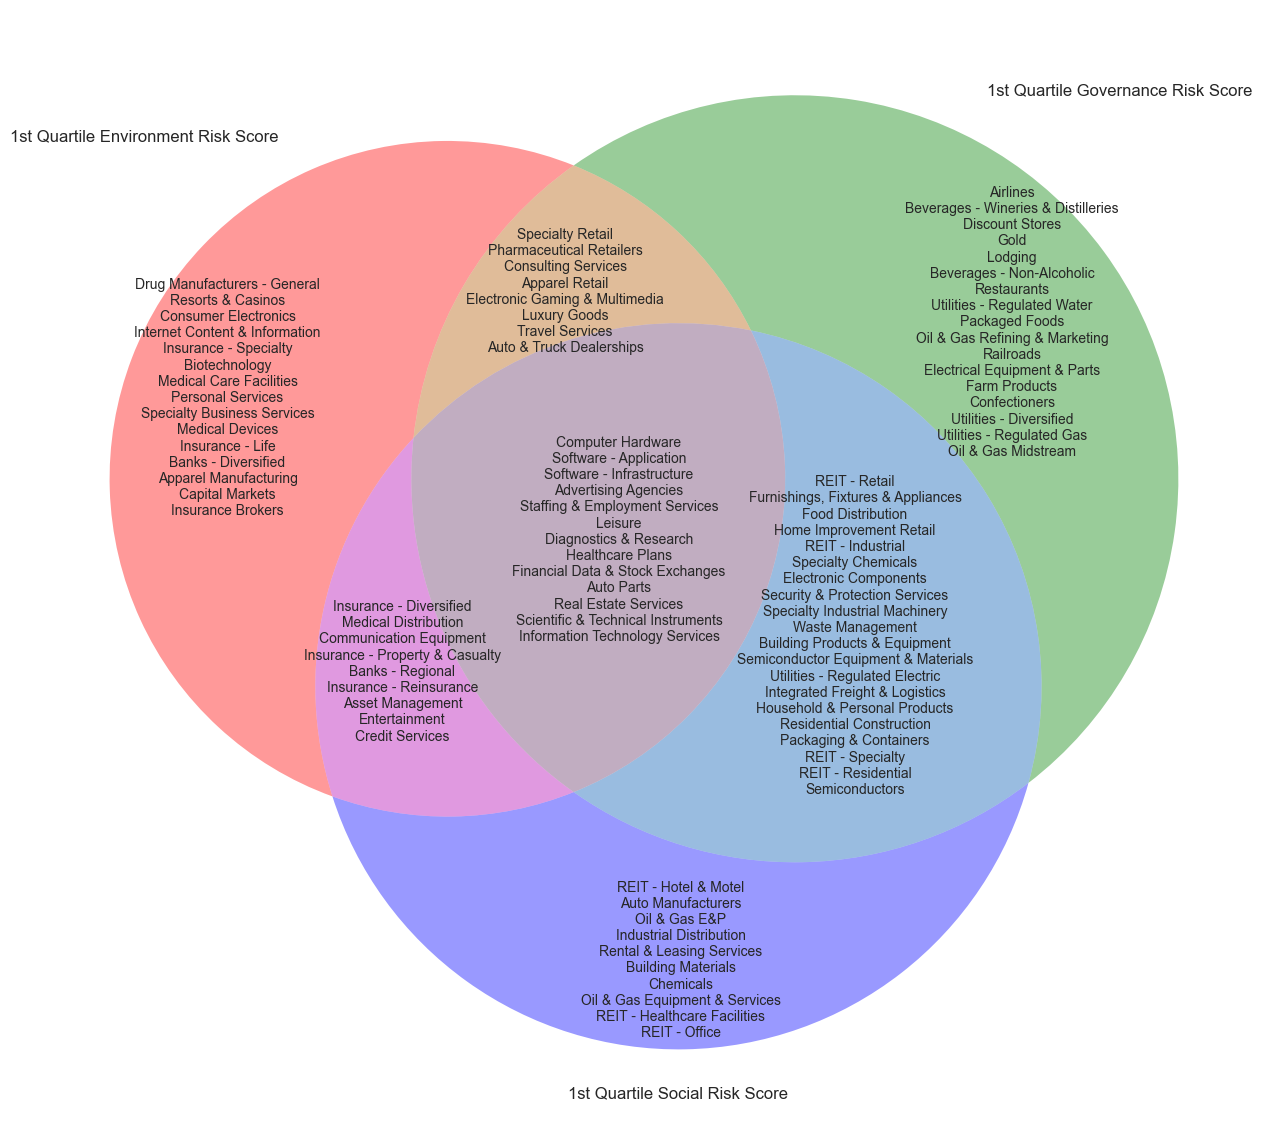

In [54]:
dataset = dataset.copy()

dataset['Industry'] = dataset['Industry'].str.strip()

quartile_columns = {
    'Environment Risk Score': 'Quartile Environment Risk Score',
    'Governance Risk Score': 'Quartile Governance Risk Score',
    'Social Risk Score': 'Quartile Social Risk Score'
}

for score_col, quartile_col in quartile_columns.items():
    dataset[quartile_col] = pd.qcut(dataset[score_col], q=4, labels=[1, 2, 3, 4])

set_1 = set(dataset.loc[dataset['Quartile Environment Risk Score'] == 1, 'Industry'])
set_2 = set(dataset.loc[dataset['Quartile Governance Risk Score'] == 1, 'Industry'])
set_3 = set(dataset.loc[dataset['Quartile Social Risk Score'] == 1, 'Industry'])

plt.figure(figsize=(16, 16))

venn = venn3([set_1, set_2, set_3], ('1st Quartile Environment Risk Score', '1st Quartile Governance Risk Score', '1st Quartile Social Risk Score'))

# Customize labels to ensure proper display
venn.get_label_by_id('100').set_text('\n'.join(set_1 - set_2 - set_3))
venn.get_label_by_id('010').set_text('\n'.join(set_2 - set_1 - set_3))
venn.get_label_by_id('001').set_text('\n'.join(set_3 - set_1 - set_2))
venn.get_label_by_id('110').set_text('\n'.join((set_1 & set_2) - set_3))
venn.get_label_by_id('101').set_text('\n'.join((set_1 & set_3) - set_2))
venn.get_label_by_id('011').set_text('\n'.join((set_2 & set_3) - set_1))
venn.get_label_by_id('111').set_text('\n'.join(set_1 & set_2 & set_3))

plt.show()


## Venn diagram for single industry:

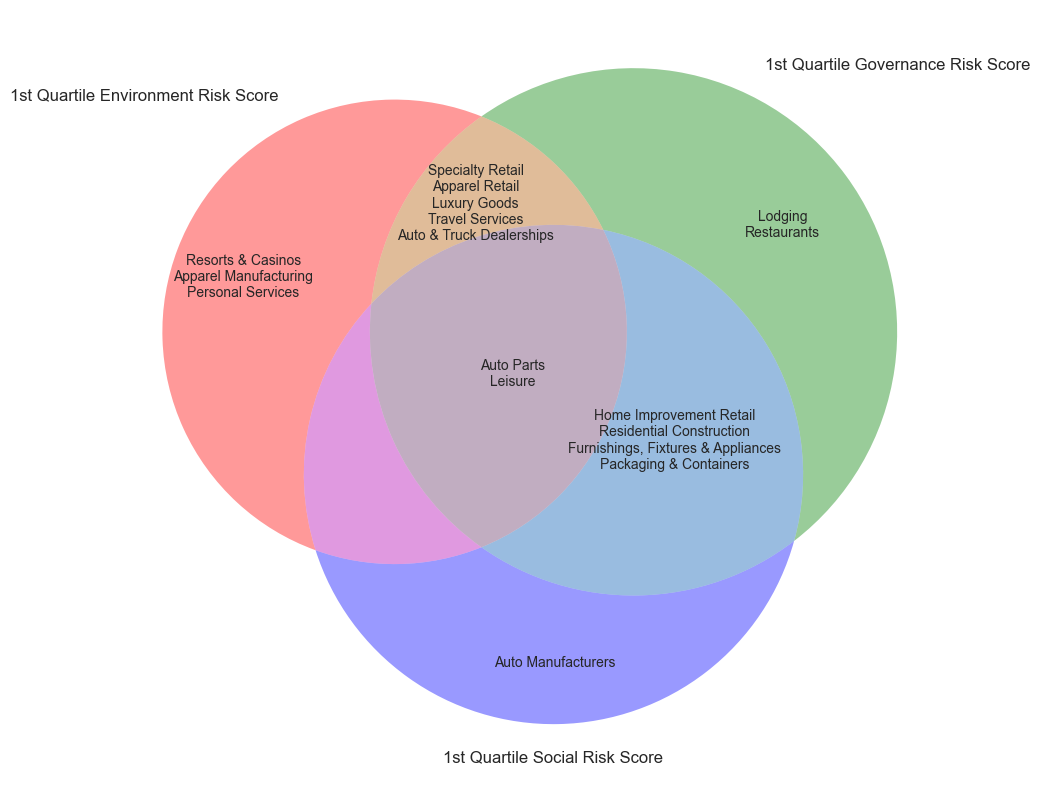

In [58]:
#Count unique industries by sector
sector_industry_counts = dataset.groupby('Sector')['Industry'].nunique()

#drop Nans for selected columns
dataset.dropna(subset=['Sector', 'Industry'], inplace=True)

industry = 'Consumer Cyclical'

sector_cut = dataset.loc[dataset['Sector'] == industry]

plt.figure(figsize=(11, 12))

set_1_sector = set(sector_cut.loc[dataset['Quartile Environment Risk Score'] == 1, 'Industry'])
set_2_sector = set(sector_cut.loc[dataset['Quartile Governance Risk Score'] == 1, 'Industry'])
set_3_sector = set(sector_cut.loc[dataset['Quartile Social Risk Score'] == 1, 'Industry'])

venn_sector = venn3([set_1, set_2, set_3], ('1st Quartile Environment Risk Score', '1st Quartile Governance Risk Score', '1st Quartile Social Risk Score'))

# Customize labels to ensure proper display
venn_sector.get_label_by_id('100').set_text('\n'.join(set_1_sector - set_2_sector - set_3_sector))
venn_sector.get_label_by_id('010').set_text('\n'.join(set_2_sector - set_1_sector - set_3_sector))
venn_sector.get_label_by_id('001').set_text('\n'.join(set_3_sector - set_1_sector - set_2_sector))
venn_sector.get_label_by_id('110').set_text('\n'.join((set_1_sector & set_2_sector) - set_3_sector))
venn_sector.get_label_by_id('101').set_text('\n'.join((set_1_sector & set_3_sector) - set_2_sector))
venn_sector.get_label_by_id('011').set_text('\n'.join((set_2_sector & set_3_sector) - set_1_sector))
venn_sector.get_label_by_id('111').set_text('\n'.join(set_1_sector & set_2_sector & set_3_sector))

plt.show()

In [57]:
sector_industry_counts

Sector
Basic Materials            7
Communication Services     5
Consumer Cyclical         19
Consumer Defensive        11
Energy                     5
Financial Services        12
Healthcare                10
Industrials               18
Real Estate                8
Technology                10
Utilities                  5
Name: Industry, dtype: int64